Attmepting to use the spiral package

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
from tempfile import NamedTemporaryFile
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from PIL import Image
from scipy.interpolate import UnivariateSpline, interp1d
from skimage.transform import rotate, rescale
import astropy.units as u
import spiralExtraction
import sdssCutoutGrab as scg
from gzbuilderspirals.galaxySpirals import GalaxySpirals
from gzbuilderspirals import deprojectArm, rThetaFromXY, xyFromRTheta

In [3]:
gal = {
    'RA': 160.65881, 'DEC': 23.95191, 'Z': 0.043594,
    'RUN': 5137, 'CAMCOL': 6, 'FIELD': 314, 'RERUN': 301,
    'SERSIC_BA': 0.576469, 'SERSIC_PHI': 43.1215,
    'PETRO_THETA': 22.2729,
}
subjectId = 14813274

In [4]:
classifications = pd.read_csv('../classifications/galaxy-builder-classifications_24-7-18.csv')
subjects = pd.read_csv('../classifications/galaxy-builder-subjects_24-7-18.csv')
null = None
true = True
false = False

In [5]:
url = 'https://panoptes-uploads.zooniverse.org/production/subject_location/6ee8db8f-2a1e-4d10-bcb9-1e5ec84f8f10.png'
print('URL of galaxy image:')
print(url)
imgData = requests.get(url).content

f = NamedTemporaryFile(suffix='.{}'.format(url.split('.')[-1]), delete=False)
f.write(imgData)
f.close()
pic = Image.open(f.name)
os.unlink(f.name)

URL of galaxy image:
https://panoptes-uploads.zooniverse.org/production/subject_location/6ee8db8f-2a1e-4d10-bcb9-1e5ec84f8f10.png


In [14]:
rotatedImage = rotate(np.array(pic), 90 - 140.62568)
stretchedImage = rescale(rotatedImage, (1, 1/s.ba))
n = int((stretchedImage.shape[1] - np.array(pic).shape[1]) / 2)

if n > 0: deprojectedImage = stretchedImage[:, n:-n]
else: deprojectedImage = stretchedImage.copy()

/Users/tlingard/anaconda/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [7]:
drawnArms = spiralExtraction.getDrawnArms(subjectId, classifications)
print('Found {} arms'.format(len(drawnArms)))

Found 65 arms


In [8]:
s = GalaxySpirals(drawnArms, ba=gal['SERSIC_BA'], phi=140.62568 - 90)
print(s.phi, s.ba, s.imageSize)

50.62567999999999 0.576469 512


In [9]:
distances = s.calculateDistances()

In [10]:
db = s.clusterLines(distances)

In [32]:
xyResult = s.fitXYSplines()
result = s.fitRadialSplines(xyResult)

In [38]:
def prettyPlot(arm, **kwargs):
    plt.plot(
        *arm.T,
        c='k'.format(i), linewidth=4
    )
    plt.plot(
        *arm.T, linewidth=3, **kwargs
    )
    plt.plot(
        *arm.T,
        c='w', linewidth=2, alpha=0.5
    )

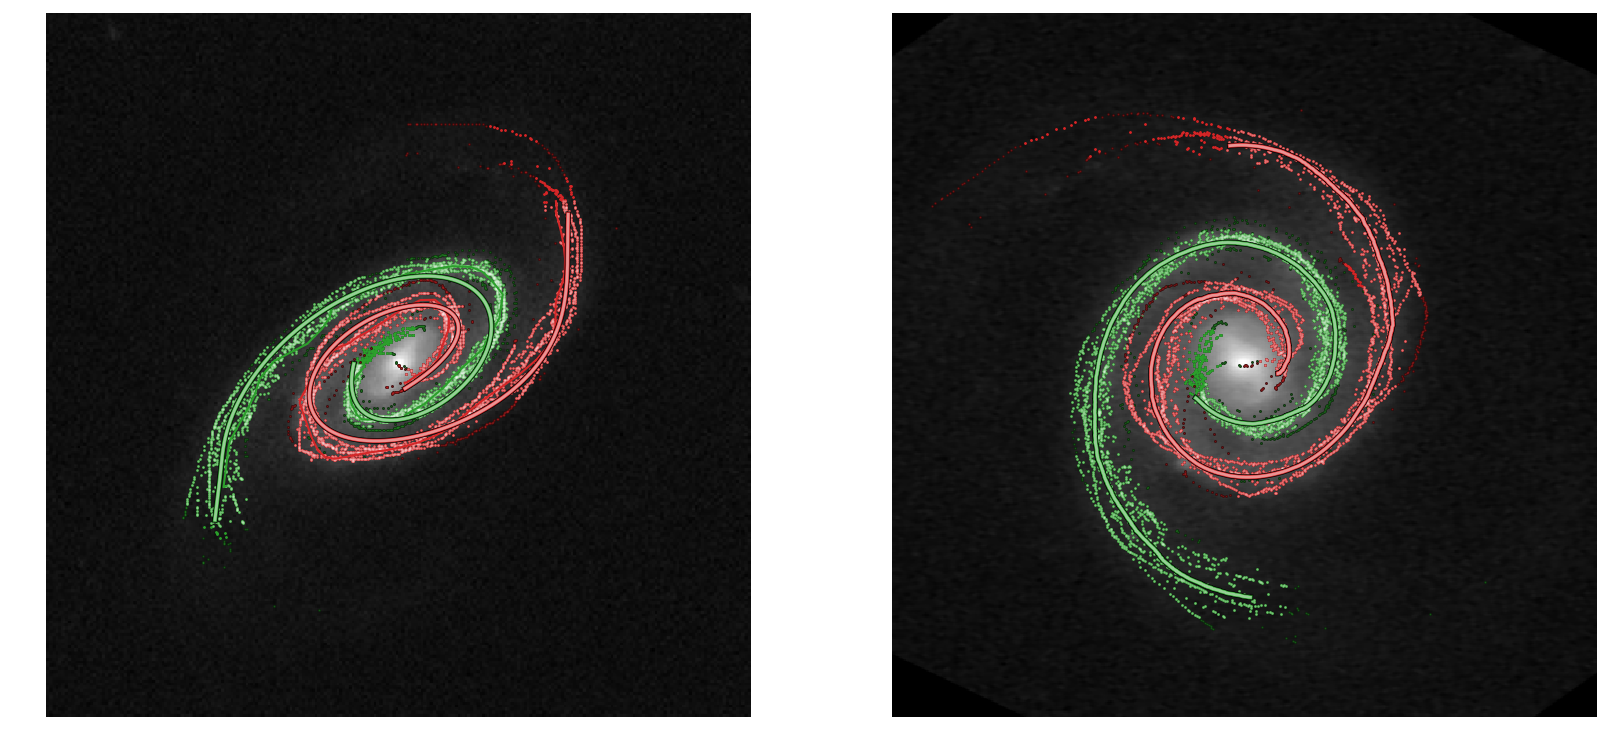

In [40]:
plt.figure(figsize=(20, 10), dpi=100)
plt.subplot(121)
plt.imshow(pic, cmap='gray', origin='lower')
for i, arm in enumerate(s.arms):
    plt.plot(*arm.pointCloud.T, 'k.', markersize=2, alpha=1)
    plt.plot(
        *arm.pointCloud.T,
        '.', c='C{}'.format(i+2), markersize=2, alpha=0.3
    )
    plt.plot(
        *arm.cleanedCloud.T,
        '.', c='C{}'.format(i+2), markersize=2, alpha=1
    )

for o in xyResult.orderings:
    plt.plot(*o.orderedPoints.T, 'w.', markersize=2, alpha=0.2)

for i, ra in enumerate(xyResult.representativeArms):
    plt.plot(*ra.T, c='C{}'.format(i+2))
t = np.linspace(0, 1, 1000)

for i, arm in enumerate(xyResult.fits):
    prettyPlot(s.arms[0].deNorm(arm), label='Arm {}'.format(i), c='C{}'.format(i+2)),

plt.axis('off')

plt.subplot(122)
plt.imshow(deprojectedImage, cmap='gray', origin='lower')
for i, arm in enumerate(result.deprojectedArms):
    plt.plot(*arm.pointCloud.T, 'k.', markersize=2, alpha=1)
    plt.plot(
        *arm.pointCloud.T,
        '.', c='C{}'.format(i+2), markersize=2, alpha=0.3
    )
    plt.plot(
        *arm.cleanedCloud.T,
        '.', c='C{}'.format(i+2), markersize=2, alpha=1
    )

for o in result.orderings:
    plt.plot(*o.orderedPoints.T, 'w.', markersize=2, alpha=0.2)
    
for i, arm in enumerate(result.radialFit):
    prettyPlot(s.arms[0].deNorm(arm), label='Arm {}'.format(i), c='C{}'.format(i+2)),

plt.axis('off')
None